### Keeping all the columns and Label Encoding them using sklearn

In [1]:
#@title Importing libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
from sklearn.metrics.pairwise import cosine_similarity
import ast
import numpy as np
import seaborn as sns
import urllib.request as request
import matplotlib.pyplot as plt
import matplotlib.image as img
import datetime as dt

In [2]:
# Plotting images using the links provided in dataset
def display_image(url):
    image = request.urlopen(url)
    image = plt.imread(image, format='WEBP')
    plt.imshow(image)

In [3]:
# Initial DataFrame
df = pd.read_csv("Fashion Dataset.csv")
df.head(5)

,p_id,name,price,colour,brand,img,ratingCount,avg_rating,description,p_attributes
0,17048614.0,Khushal K Women Black Ethnic Motifs Printed Ku...,5099.0,Black,Khushal K,http://assets.myntassets.com/assets/images/170...,4522.0,4.418399,Black printed Kurta with Palazzos with dupatta...,"{'Add-Ons': 'NA', 'Body Shape ID': '443,333,32..."
1,16524740.0,InWeave Women Orange Solid Kurta with Palazzos...,5899.0,Orange,InWeave,http://assets.myntassets.com/assets/images/165...,1081.0,4.119334,Orange solid Kurta with Palazzos with dupatta<...,"{'Add-Ons': 'NA', 'Body Shape ID': '443,333,32..."
2,16331376.0,Anubhutee Women Navy Blue Ethnic Motifs Embroi...,4899.0,Navy Blue,Anubhutee,http://assets.myntassets.com/assets/images/163...,1752.0,4.161530,Navy blue embroidered Kurta with Trousers with...,"{'Add-Ons': 'NA', 'Body Shape ID': '333,424', ..."
3,14709966.0,Nayo Women Red Floral Printed Kurta With Trous...,3699.0,Red,Nayo,http://assets.myntassets.com/assets/images/147...,4113.0,4.088986,Red printed kurta with trouser and dupatta<br>...,"{'Add-Ons': 'NA', 'Body Shape ID': '333,424', ..."
4,11056154.0,AHIKA Women Black & Green Printed Straight Kurta,1350.0,Black,AHIKA,http://assets.myntassets.com/assets/images/110...,21274.0,3.978377,"Black and green printed straight kurta, has a ...","{'Body Shape ID': '424', 'Body or Garment Size..."


In [4]:
# Dropping rows whose all values are null
df = df.dropna(how="all")

In [5]:
# Extract features from the column 'p_attributes'
for index, row in df.iterrows():

    if  not pd.isna(row['p_attributes']):
      # Get features into the dictionary format
      features_dict = ast.literal_eval(row['p_attributes'])

      # Add features as separate columns to the DataFrame
      for feature, value in features_dict.items():
          df.at[index, feature] = value

In [6]:
# Keeping first occurence of duplicate rows
duplicated_rows = df[df.duplicated(subset="p_id", keep=False)]
rows_to_delete = duplicated_rows.drop_duplicates(subset="p_id", keep="first")
df = df.drop(index=rows_to_delete.index)

In [7]:
# Dropping unnecessary columns
df = df.drop(columns=['description', 'img', 'p_attributes', 'Add-Ons', 'Body or Garment Size', 'Number of Pockets',
                      'Sustainable', 'Wash Care', 'Weave Pattern', 'Style Tip',
                      'Fabric Purity', 'Shape', 'Care for me', 'Where-to-wear', 'Wedding', 'About the Brand',
                      'Better Cotton Initiative', 'taxMaterial', 'Contact Brand or Retailer for pre-sales product queries',
                      'Collection Name', 'Brand Fit Name', 'Fabric 3', 'Reversible', 'How to care for your denim', 'What it does for your body',
                      'Technology', 'Sport Team', 'Fusion Wear', 'Set Content', 'Regions', 'Technology Present'], axis=1)

### EDA

<Axes: ylabel='Bottom Type'>

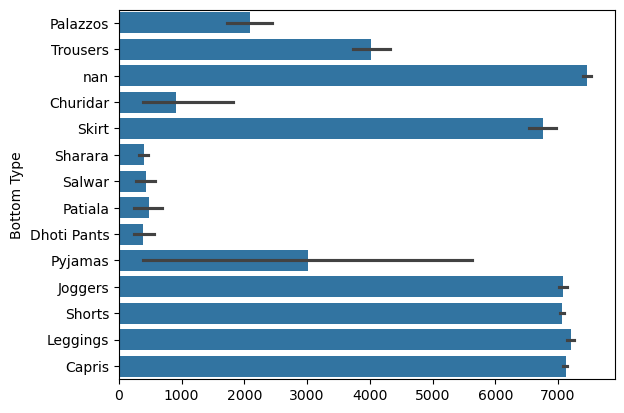

In [8]:
sns.barplot(df['Bottom Type'])

<Axes: ylabel='Top Type'>

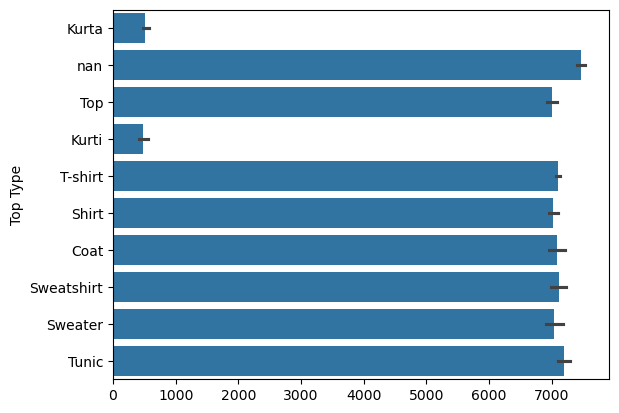

In [9]:
sns.barplot(df['Top Type'])

### Generating image embeddings

In [10]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import datetime as dt
import cv2
from tensorflow import keras
from tqdm import tqdm

2024-02-13 16:04:14.836873: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 16:04:14.836932: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 16:04:14.836974: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [11]:
# Using DenseNet 121 to generate image embeddings
model_embedding = tf.keras.applications.DenseNet121(
    include_top=False, weights='imagenet', input_tensor=None, input_shape=(512,512,3),
    pooling=None,
)

# Getting image embeddings
def get_embeddings(path):
    try:
        img = keras.utils.load_img(path, target_size=(512, 512))
        img = tf.image.convert_image_dtype(img,tf.float32)[tf.newaxis, ...]
        op = model_embedding.predict(img,steps=1, verbose=0)
        op = tf.squeeze(op, axis=None, name=None)
        op = tf.reduce_mean(op, axis=(0,1), keepdims=False, name=None).numpy()
        op = op.tolist()
    except Exception as e:
        print('get_embeddings() error: ', e)
        return None
    return op

In [12]:
# Saving image embeddings in dataframe
image_embeddings = []
images_directory = '/mnt/h/work_projects/College/RecSys_assignment/Myntra Images/images'
for idx, row in df.iterrows():
  try:
    img_embd = get_embeddings(images_directory + f'/{int(row["p_id"])}.jpg')
    image_embeddings.append(img_embd)
  except Exception as e:
    df['image_embeddings'] = image_embeddings
    df.to_csv('image_embeddings.csv')
    print(f'Error index {idx}, {e}')

get_embeddings() error:  [Errno 2] No such file or directory: '/mnt/h/work_projects/College/RecSys_assignment/Myntra Images/images/14173374.jpg'
get_embeddings() error:  [Errno 2] No such file or directory: '/mnt/h/work_projects/College/RecSys_assignment/Myntra Images/images/1639311.jpg'
get_embeddings() error:  [Errno 2] No such file or directory: '/mnt/h/work_projects/College/RecSys_assignment/Myntra Images/images/13610048.jpg'
get_embeddings() error:  [Errno 2] No such file or directory: '/mnt/h/work_projects/College/RecSys_assignment/Myntra Images/images/7779911.jpg'
get_embeddings() error:  [Errno 2] No such file or directory: '/mnt/h/work_projects/College/RecSys_assignment/Myntra Images/images/13689346.jpg'
get_embeddings() error:  [Errno 2] No such file or directory: '/mnt/h/work_projects/College/RecSys_assignment/Myntra Images/images/13691524.jpg'
get_embeddings() error:  [Errno 2] No such file or directory: '/mnt/h/work_projects/College/RecSys_assignment/Myntra Images/images/1

In [ ]:
# Saving embeddings in csv
df['image_embeddings'] = image_embeddings
df.to_csv('image_embeddings.csv')

In [ ]:
# Calculating cosine similarity between images
from sklearn.metrics.pairwise import cosine_similarity

image_similarity_matrix = cosine_similarity(df['image_embeddings'])
image_similarity_matrix.shape

In [ ]:
# Labeling prices in the range of [0, 500, 1K, 4K, 7K, 10K, 15K, 20K, 25K, 30K, 35K, 40K, 45K, 50K]

price_range = [0, 500]+list(range(1000, 13000, 3000))+list(range(15000, 55000, 5000))
df['price'] = pd.cut(df['price'], bins=price_range, include_lowest=True, labels=list(range(len(price_range)-1)))

In [ ]:
# Label Encoding all columns except name, p_id and price
le = LabelEncoder()
df.columns.difference(['name', 'p_id', 'price'])
columns_to_encode = df.columns.difference(['name', 'p_id', 'price'])
df[columns_to_encode] = df[columns_to_encode].apply(le.fit_transform)

In [ ]:
# Final DataFrame
df.head(5)

In [ ]:
# Calculating similarity between products
similarity_matrix = cosine_similarity(df.drop(['name', 'p_id'], axis=1))

In [ ]:
similarity_matrix.shape

In [ ]:
similarity_matrix

### Top 5 similar products to first product based on similarity matrix.

In [ ]:
df.iloc[0]['img']

In [ ]:
image = request.urlopen(df.iloc[0]['img'])
image = plt.imread(image, format='WEBP')
plt.imshow(image)

In [ ]:
first_product = similarity_matrix[0]
k = 5
top_k_idx = np.argsort(first_product)[-(k+1):][:-1]
top_k_idx[-1]

In [ ]:
image = request.urlopen(df.iloc[top_k_idx[-1]]['img'])
image = plt.imread(image, format='WEBP')
plt.imshow(image)

In [ ]:
image = request.urlopen(df.iloc[top_k_idx[-2]]['img'])
image = plt.imread(image, format='WEBP')
plt.imshow(image)

In [ ]:
image = request.urlopen(df.iloc[top_k_idx[-3]]['img'])
image = plt.imread(image, format='WEBP')
plt.imshow(image)

In [ ]:
image = request.urlopen(df.iloc[top_k_idx[-4]]['img'])
image = plt.imread(image, format='WEBP')
plt.imshow(image)

In [ ]:
image = request.urlopen(df.iloc[top_k_idx[-5]]['img'])
image = plt.imread(image, format='WEBP')
plt.imshow(image)